# **02807 Computational Tools for Data Science**
## **Final Project**


In [2]:
import pandas as pd
data = pd.read_csv("../data/fake reviews dataset.csv")
data.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5,CG,Very nice set. Good quality. We have had the s...


In [3]:
data.describe()

,rating
count,40432.000000
mean,4.256579
std,1.144354
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [4]:
data['rating'].value_counts()

rating
5    24559
4     7965
3     3786
1     2155
2     1967
Name: count, dtype: int64

## **K-means Clustering**

### **Import Necessary Libraries**

In [11]:
import pandas as pd
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import nltk

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joninamatt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### **Preprocess the Text Data**

In [6]:
# Load dataset
data = pd.read_csv("../data/fake reviews dataset.csv")

# Clean and filter stop words from the text data
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]  # Remove stop words
    return ' '.join(filtered_words)

# Apply text cleaning and filtering
data['cleaned_text'] = data['text_'].apply(clean_text)

### **Convert Text to TF-IDF Features**

In [7]:
# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=5000)  # Limit to top 5000 features (for efficiency)
X = vectorizer.fit_transform(data['cleaned_text'])

### **Apply K-Means Clustering**

In [8]:
# Apply k-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
data['cluster'] = kmeans.fit_predict(X)

# Show the cluster assignments
print(data[['category', 'label', 'cluster']].head())

             category label  cluster
0  Home_and_Kitchen_5    CG        1
1  Home_and_Kitchen_5    CG        4
2  Home_and_Kitchen_5    CG        4
3  Home_and_Kitchen_5    CG        1
4  Home_and_Kitchen_5    CG        1


### **Analyze the Clusters**

In [9]:
# Get the top words for each cluster
def get_top_words_for_cluster(kmeans, vectorizer, n_words=10):
    terms = vectorizer.get_feature_names_out()
    top_words = {}
    
    for i in range(kmeans.n_clusters):
        # Get the indices of the top words for this cluster
        cluster_center = kmeans.cluster_centers_[i]
        sorted_indices = cluster_center.argsort()[-n_words:][::-1]
        
        # Get the corresponding words
        top_words[i] = [terms[index] for index in sorted_indices]
    
    return top_words

# Display the top words for each cluster
top_words_by_cluster = get_top_words_for_cluster(kmeans, vectorizer)
for cluster, words in top_words_by_cluster.items():
    print(f"Cluster {cluster}: {', '.join(words)}")


Cluster 0: movie, acting, good, watch, story, great, love, action, film, one
Cluster 1: great, size, small, quality, nice, fit, little, comfortable, good, product
Cluster 2: loves, son, bought, toy, daughter, dog, great, old, christmas, play
Cluster 3: book, read, story, characters, well, series, enjoyed, good, author, reading
Cluster 4: one, love, like, great, good, use, get, well, really, time


### **Visualize the Clusters**

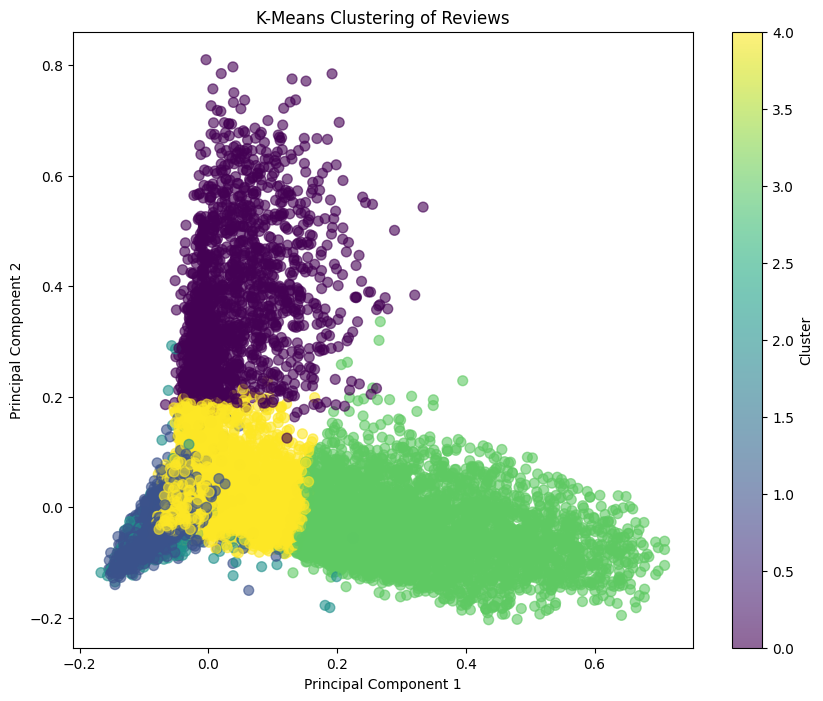

In [10]:
from sklearn.decomposition import PCA

# Reduce the dimensionality of the TF-IDF features to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# Plot the clusters in 2D
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data['cluster'], cmap='viridis', s=50, alpha=0.6)

# Add labels
plt.title("K-Means Clustering of Reviews")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster")
plt.show()